In [1]:
!pip install albumentations

     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=c838609337810446ed795cd83bb3fc5702c2a646dbb76fb7a604b481c14b64e8
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [211]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
![ ! -d "levels" ] && unzip -q "{AUX_DATA_ROOT / 'BIA_mobile_microscopy/levels_short_2.zip'}" -d levels

In [0]:
import os
import random
import numpy as np
from random import randrange

from sklearn.metrics import roc_auc_score

from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

In [25]:
import albumentations
dir(albumentations)

['BasicIAATransform',
 'BasicTransform',
 'Blur',
 'CLAHE',
 'CenterCrop',
 'ChannelShuffle',
 'Compose',
 'Crop',
 'Cutout',
 'DualIAATransform',
 'DualTransform',
 'ElasticTransform',
 'Flip',
 'FromFloat',
 'GaussNoise',
 'GridDistortion',
 'HorizontalFlip',
 'HueSaturationValue',
 'IAAAdditiveGaussianNoise',
 'IAAAffine',
 'IAACropAndPad',
 'IAAEmboss',
 'IAAFliplr',
 'IAAFlipud',
 'IAAPerspective',
 'IAAPiecewiseAffine',
 'IAASharpen',
 'IAASuperpixels',
 'ImageOnlyIAATransform',
 'ImageOnlyTransform',
 'InvertImg',
 'JpegCompression',
 'LongestMaxSize',
 'MedianBlur',
 'MotionBlur',
 'NoOp',
 'Normalize',
 'OneOf',
 'OneOrOther',
 'OpticalDistortion',
 'PadIfNeeded',
 'RGBShift',
 'RandomBrightness',
 'RandomBrightnessContrast',
 'RandomContrast',
 'RandomCrop',
 'RandomCropNearBBox',
 'RandomGamma',
 'RandomRotate90',
 'RandomScale',
 'RandomSizedBBoxSafeCrop',
 'RandomSizedCrop',
 'Resize',
 'Rotate',
 'ShiftScaleRotate',
 'SmallestMaxSize',
 'ToFloat',
 'ToGray',
 'Transpose',

In [0]:
import albumentations
from albumentations.pytorch.transforms import ToTensor
from albumentations import (
    Compose,
    RandomCrop,
    Normalize,
    VerticalFlip,
    Rotate,
    RandomGamma,
    RandomBrightnessContrast,
    OneOf,
    ShiftScaleRotate,
    JpegCompression,
    RandomBrightness,
)


class RandomOffset(albumentations.core.transforms_interface.DualTransform):
    """Random Offset for image in log scales.

    Args:
        min_offset (float): minimum value for offset
        max_offset (float): minimum value for offset
    
    Targets:
        image
    """

    def __init__(self, min_offset=1, max_offset=1000, always_apply=False, p=1.0):
        super(RandomOffset, self).__init__(always_apply, p)

        self.min_offset = min_offset
        self.max_offset = max_offset

    def apply(self, image, **params):
        offset = 10.0 ** np.random.uniform(np.log10(self.min_offset), np.log10(self.max_offset), [1])[0]
        return image + offset

    def get_transform_init_args_names(self):
        return "min_offset", "max_offset"

In [0]:
class FocusLevelDataset(Dataset):
    def __init__(self, data_path, positions_transofrms, color_transform):
        self.images = []
        self.labels = []
        self.masks = []
        self.width = 768
        self.height = 1024
        self.positions_transofrms = positions_transofrms
        self.color_transform = color_transform
        self.torch_transform = Compose([
            Normalize([0.5], [0.5]),
            ToTensor(),
        ])

        for dir_name in os.listdir(data_path):
            for dir_path, dir_names, file_names in os.walk(os.path.join(data_path, dir_name)):
                if len(dir_names) == 0:       # We are inside folder with specimen

                    # Add grayscaled images
                    for frame in (sorted(file_names, reverse=True)[:10]):
                        img = Image.open(os.path.join(dir_path, frame)).convert('L')
                        self.images.append(img)

                    # Add labels -- 0 means the most focused image
                    self.labels += list(range(10))

                    # Extracting mask for every scpecimen
                    most_blurred_image = cv2.imread(os.path.join(dir_path, sorted(file_names)[0]), 0)
                    _, mask = cv2.threshold(np.array(most_blurred_image), 20, 255, cv2.THRESH_BINARY_INV)
                    for _ in range(len(file_names)):
                        self.masks.append(mask == 0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = np.array(self.images[idx])
        mask = np.array(self.masks[idx]).astype(np.uint8)

        # cropped = self.random_crop(image=img, mask=mask)
        # img, mask = cropped['image'], cropped['mask']
        transformed = self.positions_transofrms(image=img, mask=mask)
        img, mask = transformed['image'], transformed['mask']
        
        img = self.color_transform(image=img)['image']
        img = self.torch_transform(image=img)['image'].T.unsqueeze(0)
        

        label = self.labels[idx]
        mean_mask = mask.mean()
        if mean_mask < 0.5: # If more than 50% of image is not in mask, image will label as not focused
            label = 9
        elif mean_mask < 0.75: # If more than 75% of image is not in mask, image will label as focused twice worse
            label = min(9, label + label / 2)

        return img, int(label), mask

In [0]:
CROP_SIZE = 84
BATCH_SIZE = 8

positions_transofrms = Compose([
    RandomCrop(CROP_SIZE, CROP_SIZE, p=1.0),
    # Rotate(p=0.5),
    # JpegCompression(p=0.5),
    ShiftScaleRotate(rotate_limit=45, p=0.95),
    VerticalFlip(p=0.5),
])

color_transform = Compose([
    RandomOffset(p=0.5),
    # RandomBrightness(p=0.5)
    # OneOf([
    #        RandomGamma((90, 110), p=0.1),
    #        RandomBrightnessContrast(0.1, 0.1, p=0.1),
    # ]),
])


dataset = FocusLevelDataset("./levels", positions_transofrms, color_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [0]:
![ ! -d "focus_level_dataset" ] && unzip -q "{AUX_DATA_ROOT / 'BIA_mobile_microscopy/focus_level_dataset.zip'}" -d focus_level_dataset

In [0]:
class FocusLevelDatasetValidation(Dataset):
    def __init__(self, focused_path, unfocused_path, transform):
        self.images = []
        self.labels = []
        self.transform = transform

        for img in sorted(os.listdir(focused_path)):
          img_path = os.path.join(focused_path, img)
          img = Image.open(img_path).convert('L')
          self.images.append(img)
          self.labels.append(0)
        
        for img in sorted(os.listdir(unfocused_path)):
          img_path = os.path.join(unfocused_path, img)
          img = Image.open(img_path).convert('L')
          self.images.append(img)
          self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img = np.array(self.images[idx])
      img = self.transform(image=img)['image'].T.unsqueeze(0)
      return img, self.labels[idx]

test_transform = Compose([
    Normalize([0.5], [0.5]),
    ToTensor(),
])

val_dataset = FocusLevelDatasetValidation('./focus_level_dataset/focus_level_dataset/validation/focused',
                                          './focus_level_dataset/focus_level_dataset/validation/unfocused',
                                          transform=test_transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

LABEL:  1


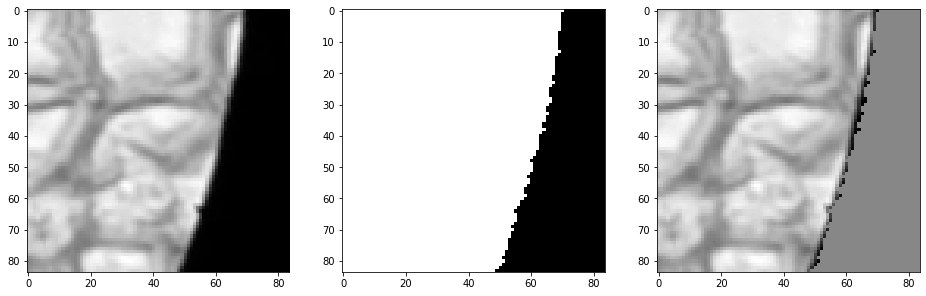

In [340]:
_img, y, mask = dataset[1]
img = _img[0].numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.imshow(img, cmap='gray')
ax2.imshow(mask, cmap='gray')
ax3.imshow(img * mask, cmap='gray')
print("LABEL: ", y)

In [0]:
def ranked_probability_score(targets, predictions, axis=1):
    cdf_pred = torch.cumsum(predictions, axis=axis)
    cdf_target = torch.cumsum(targets, axis=axis)
    
    values = (cdf_pred - cdf_target) ** 2
    rps = torch.sum(values, axis=axis)
    return rps

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super(ConvBlock, self).__init__()
        self.batch_norm = batch_norm

        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.maxpool2d = nn.MaxPool2d(2, stride=2, padding=0)
    
    def forward(self, x):
        x = self.relu(self.conv2d(x))
        if self.batch_norm:
            x = self.bn(x)
        return self.maxpool2d(x)


class CNNModel(nn.Module):
    def __init__(self, im_size, num_classes=10, num_conv_layers=2, dropout=0.5, batch_norm=False):
        super(CNNModel, self).__init__()

        self.im_size = im_size
        self.num_conv_layers = num_conv_layers
        self.size_after_convs = int(im_size / 2**num_conv_layers)
        self.num_classes = num_classes
        self.batch_norm = batch_norm

        self.conv_layers = nn.Sequential(*[
            ConvBlock(max(1, s), s+32, batch_norm=batch_norm) for s in range(0, 32*self.num_conv_layers, 32)
        ])

        self.ft = nn.Sequential(
            nn.Linear(32*self.num_conv_layers * self.size_after_convs * self.size_after_convs, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.ft2 = nn.Sequential(
            nn.Linear(1024, self.num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 32*self.num_conv_layers * self.size_after_convs * self.size_after_convs)
        x = self.ft(x)
        x = self.ft2(x)
        return x

In [0]:
 def check_accuracy(model, loader, th=5):
  model.eval()
  acc = 0
  for x, y in loader:
    x = x.to(device)
    pred_ind = model(x).argmax().cpu().detach().numpy()
    acc += int(int((pred_ind > th)) == y)
  
  return acc / len(val_dataloader)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNModel(CROP_SIZE, num_conv_layers=2, batch_norm=True)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criteria = nn.CrossEntropyLoss()

tb_writer = SummaryWriter()

In [348]:
%load_ext tensorboard
%tensorboard --logdir ./runs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [0]:
num_epochs = 1500

def to_one_hot_vector(num_class, label):
  b = np.zeros((label.shape[0], num_class))
  b[np.arange(label.shape[0]), label] = 1
  return b

for epoch in range(num_epochs):
    model.train()
    mean_loss = 0.0
    for x, y, mask in dataloader:
        predicitons = model(x.to(device))
        loss = torch.mean(ranked_probability_score(torch.tensor(to_one_hot_vector(10, y)).to(device), predicitons))
        # print(loss.cpu().detach().item())
        mean_loss += loss.cpu().detach().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tb_writer.add_scalar("train/loss", mean_loss / len(dataloader), epoch+1)
    tb_writer.add_scalar("val/accuracy", check_accuracy(model, val_dataloader), epoch+1) 

In [0]:
from PIL import Image, ImageDraw 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def draw_grid(image_path):
  img = Image.open(image_path)
  cdict = {'red':   [(0.0, 1.0, 1.0),  # red decreases
                    (1.0, 0.0, 0.0)],

          'green': [(0.0, 0.0, 0.0),  # green increases
                    (1.0, 1.0, 1.0)],

          'blue':  [(0.0, 0.0, 0.0),  # no blue at all
                    (1.0, 0.0, 0.0)] }
  
  N = 10

  red_green_cm = LinearSegmentedColormap('RedGreen', cdict, N)

  colors = cm.get_cmap(red_green_cm, N)
  
  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]
  print(cmaplist)


  img1 = ImageDraw.Draw(img)   

  img_gray = img.convert('L')
  for i in range(img.size[0] // CROP_SIZE):
    for j in range(img.size[1] // CROP_SIZE):
      shape = (CROP_SIZE * i, CROP_SIZE * j, CROP_SIZE * (i + 1), CROP_SIZE * (j + 1))
      cropped = np.array(img_gray.crop(shape))
      pred = model(test_transform(image=cropped)['image'].to(device).unsqueeze(0).unsqueeze(0))
      color_num = pred.argmax().cpu().detach().numpy()
    #   print(f"i={i},j={j},pred={pred}")
      c = colors(color_num)
      c = (int(c[0] * 255), int(c[1] * 255), int(c[2] * 255))
      img1.rectangle(shape, outline = c, width=3) #colors(color_num)) 


  plt.figure(figsize=(10, 10))
  plt.imshow(img)

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.0, 0.517825311942959, 1.0), (0.0, 0.0, 0.535650623885918, 1.0), (0.0, 0.0, 0.553475935828877, 1.0), (0.0, 0.0, 0.571301247771836, 1.0), (0.0, 0.0, 0.589126559714795, 1.0), (0.0, 0.0, 0.606951871657754, 1.0), (0.0, 0.0, 0.624777183600713, 1.0), (0.0, 0.0, 0.642602495543672, 1.0), (0.0, 0.0, 0.660427807486631, 1.0), (0.0, 0.0, 0.67825311942959, 1.0), (0.0, 0.0, 0.696078431372549, 1.0), (0.0, 0.0, 0.713903743315508, 1.0), (0.0, 0.0, 0.731729055258467, 1.0), (0.0, 0.0, 0.749554367201426, 1.0), (0.0, 0.0, 0.767379679144385, 1.0), (0.0, 0.0, 0.785204991087344, 1.0), (0.0, 0.0, 0.803030303030303, 1.0), (0.0, 0.0, 0.820855614973262, 1.0), (0.0, 0.0, 0.838680926916221, 1.0), (0.0, 0.0, 0.85650623885918, 1.0), (0.0, 0.0, 0.874331550802139, 1.0), (0.0, 0.0, 0.892156862745098, 1.0), (0.0, 0.0, 0.909982174688057, 1.0), (0.0, 0.0, 0.927807486631016, 1.0), (0.0, 0.0, 0.945632798573975, 1.0), (0.0, 0.0, 0.963458110516934, 1.0), (0.0, 0.0, 0.981283422459893, 1.0), (0.0, 0

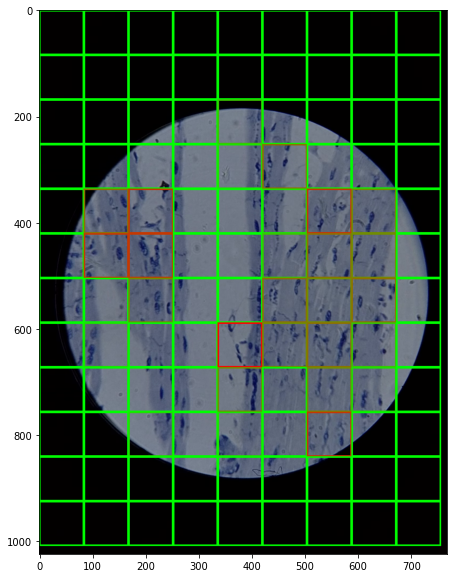

In [369]:
model.eval()

draw_grid('./745.png')

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.0, 0.517825311942959, 1.0), (0.0, 0.0, 0.535650623885918, 1.0), (0.0, 0.0, 0.553475935828877, 1.0), (0.0, 0.0, 0.571301247771836, 1.0), (0.0, 0.0, 0.589126559714795, 1.0), (0.0, 0.0, 0.606951871657754, 1.0), (0.0, 0.0, 0.624777183600713, 1.0), (0.0, 0.0, 0.642602495543672, 1.0), (0.0, 0.0, 0.660427807486631, 1.0), (0.0, 0.0, 0.67825311942959, 1.0), (0.0, 0.0, 0.696078431372549, 1.0), (0.0, 0.0, 0.713903743315508, 1.0), (0.0, 0.0, 0.731729055258467, 1.0), (0.0, 0.0, 0.749554367201426, 1.0), (0.0, 0.0, 0.767379679144385, 1.0), (0.0, 0.0, 0.785204991087344, 1.0), (0.0, 0.0, 0.803030303030303, 1.0), (0.0, 0.0, 0.820855614973262, 1.0), (0.0, 0.0, 0.838680926916221, 1.0), (0.0, 0.0, 0.85650623885918, 1.0), (0.0, 0.0, 0.874331550802139, 1.0), (0.0, 0.0, 0.892156862745098, 1.0), (0.0, 0.0, 0.909982174688057, 1.0), (0.0, 0.0, 0.927807486631016, 1.0), (0.0, 0.0, 0.945632798573975, 1.0), (0.0, 0.0, 0.963458110516934, 1.0), (0.0, 0.0, 0.981283422459893, 1.0), (0.0, 0

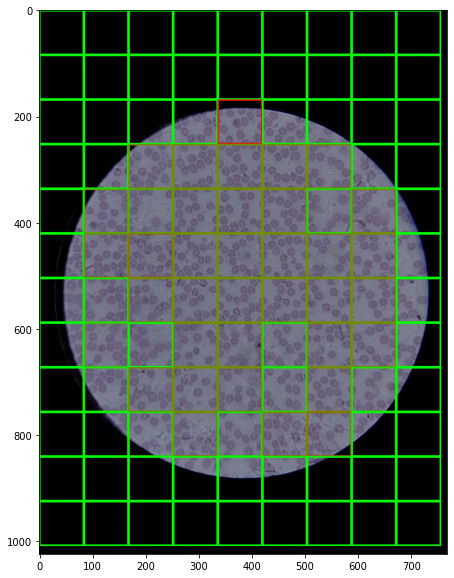

In [370]:
draw_grid('763.png')

In [0]:
 def check_accuracy(model, loader, th=5):
  model.eval()
  acc = 0
  for x, y in loader:
    x = x.to(device)
    pred_ind = model(x).argmax().cpu().detach().numpy()
    acc += int(int((pred_ind > th)) == y)
  
  return acc / len(val_dataloader)

res = []
for th in np.arange(1, 10):
    acc = check_accuracy(model, val_dataloader)
    res.append((th, acc))

In [372]:
sorted(res, key=lambda x: x[0])[-10:]

[(1, 0.935064935064935),
 (2, 0.935064935064935),
 (3, 0.935064935064935),
 (4, 0.935064935064935),
 (5, 0.935064935064935),
 (6, 0.935064935064935),
 (7, 0.935064935064935),
 (8, 0.935064935064935),
 (9, 0.935064935064935)]

In [353]:
draw_grid('391.png')

FileNotFoundError: ignored

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.0, 0.517825311942959, 1.0), (0.0, 0.0, 0.535650623885918, 1.0), (0.0, 0.0, 0.553475935828877, 1.0), (0.0, 0.0, 0.571301247771836, 1.0), (0.0, 0.0, 0.589126559714795, 1.0), (0.0, 0.0, 0.606951871657754, 1.0), (0.0, 0.0, 0.624777183600713, 1.0), (0.0, 0.0, 0.642602495543672, 1.0), (0.0, 0.0, 0.660427807486631, 1.0), (0.0, 0.0, 0.67825311942959, 1.0), (0.0, 0.0, 0.696078431372549, 1.0), (0.0, 0.0, 0.713903743315508, 1.0), (0.0, 0.0, 0.731729055258467, 1.0), (0.0, 0.0, 0.749554367201426, 1.0), (0.0, 0.0, 0.767379679144385, 1.0), (0.0, 0.0, 0.785204991087344, 1.0), (0.0, 0.0, 0.803030303030303, 1.0), (0.0, 0.0, 0.820855614973262, 1.0), (0.0, 0.0, 0.838680926916221, 1.0), (0.0, 0.0, 0.85650623885918, 1.0), (0.0, 0.0, 0.874331550802139, 1.0), (0.0, 0.0, 0.892156862745098, 1.0), (0.0, 0.0, 0.909982174688057, 1.0), (0.0, 0.0, 0.927807486631016, 1.0), (0.0, 0.0, 0.945632798573975, 1.0), (0.0, 0.0, 0.963458110516934, 1.0), (0.0, 0.0, 0.981283422459893, 1.0), (0.0, 0

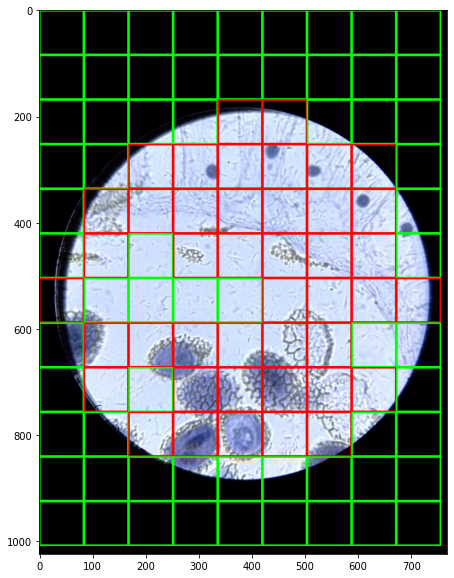

In [0]:
draw_grid('465.png')

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.0, 0.517825311942959, 1.0), (0.0, 0.0, 0.535650623885918, 1.0), (0.0, 0.0, 0.553475935828877, 1.0), (0.0, 0.0, 0.571301247771836, 1.0), (0.0, 0.0, 0.589126559714795, 1.0), (0.0, 0.0, 0.606951871657754, 1.0), (0.0, 0.0, 0.624777183600713, 1.0), (0.0, 0.0, 0.642602495543672, 1.0), (0.0, 0.0, 0.660427807486631, 1.0), (0.0, 0.0, 0.67825311942959, 1.0), (0.0, 0.0, 0.696078431372549, 1.0), (0.0, 0.0, 0.713903743315508, 1.0), (0.0, 0.0, 0.731729055258467, 1.0), (0.0, 0.0, 0.749554367201426, 1.0), (0.0, 0.0, 0.767379679144385, 1.0), (0.0, 0.0, 0.785204991087344, 1.0), (0.0, 0.0, 0.803030303030303, 1.0), (0.0, 0.0, 0.820855614973262, 1.0), (0.0, 0.0, 0.838680926916221, 1.0), (0.0, 0.0, 0.85650623885918, 1.0), (0.0, 0.0, 0.874331550802139, 1.0), (0.0, 0.0, 0.892156862745098, 1.0), (0.0, 0.0, 0.909982174688057, 1.0), (0.0, 0.0, 0.927807486631016, 1.0), (0.0, 0.0, 0.945632798573975, 1.0), (0.0, 0.0, 0.963458110516934, 1.0), (0.0, 0.0, 0.981283422459893, 1.0), (0.0, 0

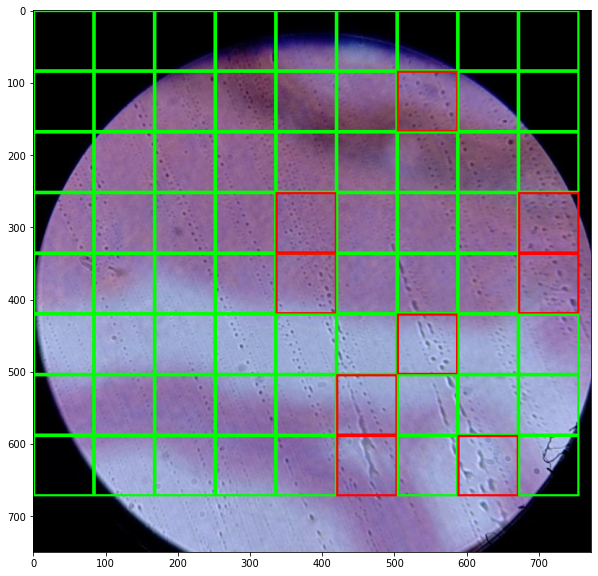

In [0]:
draw_grid('photo_2020-05-28 23.27.29.jpeg')